# Config

In [1]:
import json
from IPython.display import Image 
from sklearn.cluster import KMeans
from keras.engine.topology import Layer, InputSpec
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Activation, Input, Lambda, Dot, Subtract, Multiply, Concatenate, BatchNormalization
from keras import backend as K
from keras.utils import np_utils, plot_model
from keras.optimizers import Adam, SGD
from keras.losses import KLD
from keras.callbacks import ModelCheckpoint
import numpy as np
import tensorflow as tf
from itertools import permutations
import colorsys
import random
import os
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [5]:
data_path = './data/paired_small.json'
model_path = './model'
fully_observed = False


with open(data_path, 'r', encoding='utf8') as f:
    data_dic = json.loads(f.read())
    
    
data = np.array(data_dic['data'], dtype='float32')
# shuffle data
np.random.shuffle(data)
# split train-test set
train_split = int(data_dic['size'] * 9 / 10)
train = data[:train_split]
test = data[train_split:]

if 'fully_observed' in data_dic and data_dic['fully_observed']:
    fully_observed = True
    
    D_train = train[:, :data_dic['donor_dim']]
    R_train = train[:, data_dic['recipientID_col']+1:data_dic['recipientID_col']+1+data_dic['recipient_dim']]
    y_full_train = train[:, -data_dic['n_class']-1:-1]
    t_train = train[:, -1].astype('int')
    y_train = y_full_train[np.arange(len(t_train)), t_train]

    D_test = test[:, :data_dic['donor_dim']]
    R_test = test[:, data_dic['recipientID_col']+1:data_dic['recipientID_col']+1+data_dic['recipient_dim']]
    y_full_test = test[:, -data_dic['n_class']-1:-1]
    t_test = test[:, -1].astype('int')
    y_test = y_full_test[np.arange(len(t_test)), t_test]
else:
    D_train = train[:, :data_dic['donor_dim']]
    R_train = train[:, data_dic['recipientID_col']+1:data_dic['recipientID_col']+1+data_dic['recipient_dim']]
    y_train = train[:, -1]

    D_test = test[:, :data_dic['donor_dim']]
    R_test = test[:, data_dic['recipientID_col']+1:data_dic['recipientID_col']+1+data_dic['recipient_dim']]
    y_test = test[:, -1]
    
    
X_train = np.hstack([D_train, R_train])
X_test = np.hstack([D_test, R_test])

DD = data[:, :data_dic['donor_dim']]
RR = data[:, data_dic['recipientID_col']+1:data_dic['recipientID_col']+1+data_dic['recipient_dim']]
np.random.shuffle(DD)
np.random.shuffle(RR)
SS = np.absolute(np.arange(len(DD)) + np.random.normal(0, 1000, size=len(DD)).astype('int'))

In [6]:
n_clusters = 3
# fully_observed = False

rdims = [48, 96, 20]
bdims = [48, 48, 96]
cdims = [D_train.shape[-1], 48, 96]
AEdims = [D_train.shape[-1], 48, 48, 96, 5]


def plot_cluster(kmeansdata, label_list, num_cluster, scale=10):
    """
    Function to convert the n-dimensional cluster to 
    2-dimensional cluster and plotting 50 random clusters
    file%d.png    -> file where the output is stored indexed
                     by first available file index
                     e.g. file1.png , file2.png ...
    """
    pca = PCA(2)
    pca.fit(kmeansdata)
    users_2d = pca.transform(kmeansdata)

    plt.figure()
    plt.xlim([users_2d[:, 0].min() - scale, users_2d[:, 0].max() + scale])
    plt.ylim([users_2d[:, 1].min() - scale, users_2d[:, 1].max() + scale])


    # Plotting only the points whose centers were plotted
    # Points are represented as a small '+' marker
    for i, position in enumerate(label_list):
        plt.scatter(users_2d[i, 0], users_2d[i, 1] , marker='+' , c=[colors[position]])

#     filename = "sDEC"
#     i = 0
#     while True:
#         if os.path.isfile(filename + str(i) + ".png") == False:
#             #new index found write file and return
#             plt.savefig(filename + str(i) + ".png")
#             break
#         else:
#             #Changing index to next number
#             i = i + 1
    return


colors = [(1, 0, 0), (0, 1, 0), (0, 0, 0), (0, 0, 1), (1, 1, 0), (1, 0, 1), (0, 1, 1), (.5, .1, .1)]

# regression model

In [7]:
def REGModel():
    inp = Input(shape=(X_train.shape[-1], ), name='pair_input')
    x = BatchNormalization()(inp)
    for i in range(len(rdims)):
        x = Dense(rdims[i], activation='relu', kernel_initializer='normal')(x)
    out = Dense(1, activation='relu', kernel_initializer='normal')(x)
    
    return Model(inputs=inp, outputs=out)


REG = REGModel()

## train regression model

In [5]:
REG.compile(optimizer='Adam', loss='mean_squared_error')
checkpointer = ModelCheckpoint(filepath='./model/REGCheckpoint', verbose=1, save_best_only=True)
REG.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=256, epochs=150, callbacks=[checkpointer])

REG.load_weights('./model/REGCheckpoint')
REG.save_weights('./model/REGweights')





Train on 4014 samples, validate on 446 samples
Epoch 1/150





4014/4014 [==============================] - 2s 423us/step - loss: 2434897.2953 - val_loss: 2564396.3688

Epoch 00001: val_loss improved from inf to 2564396.36883, saving model to ./model/REGCheckpoint
Epoch 2/150
4014/4014 [==============================] - 0s 14us/step - loss: 2434174.1913 - val_loss: 2562832.4092

Epoch 00002: val_loss improved from 2564396.36883 to 2562832.40919, saving model to ./model/REGCheckpoint
Epoch 3/150
4014/4014 [==============================] - 0s 12us/step - loss: 2430334.8935 - val_loss: 2555212.1132

Epoch 00003: val_loss improved from 2562832.40919 to 2555212.11323, saving model to ./model/REGCheckpoint
Epoch 4/150
4014/4014 [==============================] - 0s 13us/step - loss: 2413685.9920 - val_loss: 2524862.5437

Epoch 00004: val_loss improved from 2555212.11323 to 2524862.54372, saving model to ./model/REGCheckpoint
Epoch 5/150
4014/4014 [==============================] - 0s 1


Epoch 00072: val_loss improved from 404905.48220 to 404841.78672, saving model to ./model/REGCheckpoint
Epoch 73/150
4014/4014 [==============================] - 0s 15us/step - loss: 414158.2562 - val_loss: 409067.3572

Epoch 00073: val_loss did not improve from 404841.78672
Epoch 74/150
4014/4014 [==============================] - 0s 14us/step - loss: 419005.7936 - val_loss: 405096.8061

Epoch 00074: val_loss did not improve from 404841.78672
Epoch 75/150
4014/4014 [==============================] - 0s 13us/step - loss: 413983.7261 - val_loss: 404768.7113

Epoch 00075: val_loss improved from 404841.78672 to 404768.71132, saving model to ./model/REGCheckpoint
Epoch 76/150
4014/4014 [==============================] - 0s 14us/step - loss: 414196.4299 - val_loss: 405788.3446

Epoch 00076: val_loss did not improve from 404768.71132
Epoch 77/150
4014/4014 [==============================] - 0s 13us/step - loss: 415917.1538 - val_loss: 406503.5636

Epoch 00077: val_loss did not improve from 

4014/4014 [==============================] - 0s 13us/step - loss: 396182.3055 - val_loss: 405199.3721

Epoch 00119: val_loss did not improve from 402770.81712
Epoch 120/150
4014/4014 [==============================] - 0s 13us/step - loss: 392826.9949 - val_loss: 404445.8540

Epoch 00120: val_loss did not improve from 402770.81712
Epoch 121/150
4014/4014 [==============================] - 0s 14us/step - loss: 396036.0855 - val_loss: 406525.1833

Epoch 00121: val_loss did not improve from 402770.81712
Epoch 122/150
4014/4014 [==============================] - 0s 13us/step - loss: 391931.4204 - val_loss: 406003.5940

Epoch 00122: val_loss did not improve from 402770.81712
Epoch 123/150
4014/4014 [==============================] - 0s 13us/step - loss: 393462.6132 - val_loss: 405344.6495

Epoch 00123: val_loss did not improve from 402770.81712
Epoch 124/150
4014/4014 [==============================] - 0s 13us/step - loss: 392745.6826 - val_loss: 407193.1015

Epoch 00124: val_loss did not im

# SCCN

In [8]:
def autoencoder(dims, act='relu', init='random_normal'):
    """
    Fully connected auto-encoder model
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_layers = len(dims) - 1
    # input
    inp = Input(shape=(dims[0],), name='AEinput')
    x = BatchNormalization()(inp)
    # internal layers in encoder
    for i in range(n_layers-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_layers - 1))(x)

    x = encoded
    # internal layers in decoder
    for i in range(n_layers-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

    # output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    decoded = x
    return Model(inputs=inp, outputs=decoded, name='AE'), Model(inputs=inp, outputs=encoded, name='encoder')

AE, encoder = autoencoder(AEdims)


class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: degrees of freedom parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight((self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.        
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
        Arguments:
            inputs: data, shape=(n_samples, n_features)
        Return:
            q: soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure each sample's values add up to 1.
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


# target distribution of DEC    
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T


clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
DEC = Model(inputs=encoder.input, outputs=clustering_layer)

# Initialize cluster centers using k-means.
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
D_clus = kmeans.fit_predict(encoder.predict(D_train))
D_clus_pre = np.copy(D_clus)
DEC.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

## train AE

In [7]:
AE.compile(optimizer='Adam', loss='mse')
AE.fit(D_train, D_train, batch_size=256, epochs=300)

AE.save_weights(model_path + '/AEweights')
encoder.save_weights(model_path + '/encoderweights')

Epoch 1/300
4014/4014 [==============================] - 0s 103us/step - loss: 16689086751.7608
Epoch 2/300
4014/4014 [==============================] - 0s 19us/step - loss: 16689074068.8550
Epoch 3/300
4014/4014 [==============================] - 0s 19us/step - loss: 16688781994.6667
Epoch 4/300
4014/4014 [==============================] - 0s 19us/step - loss: 16683137831.6692
Epoch 5/300
4014/4014 [==============================] - 0s 18us/step - loss: 16612528165.2456
Epoch 6/300
4014/4014 [==============================] - 0s 18us/step - loss: 16008070596.5600
Epoch 7/300
4014/4014 [==============================] - 0s 17us/step - loss: 12368313281.7539
Epoch 8/300
4014/4014 [==============================] - 0s 17us/step - loss: 3380391336.6258
Epoch 9/300
4014/4014 [==============================] - 0s 16us/step - loss: 1241222215.1430
Epoch 10/300
4014/4014 [==============================] - 0s 16us/step - loss: 696836785.7459
Epoch 11/300
4014/4014 [============================

4014/4014 [==============================] - 0s 16us/step - loss: 26266448.7733
Epoch 176/300
4014/4014 [==============================] - 0s 17us/step - loss: 19681905.3204
Epoch 177/300
4014/4014 [==============================] - 0s 17us/step - loss: 16821310.5750
Epoch 178/300
4014/4014 [==============================] - 0s 17us/step - loss: 17092442.1754
Epoch 179/300
4014/4014 [==============================] - 0s 17us/step - loss: 25542057.6821
Epoch 180/300
4014/4014 [==============================] - 0s 19us/step - loss: 24664021.6627
Epoch 181/300
4014/4014 [==============================] - 0s 17us/step - loss: 21725197.4778
Epoch 182/300
4014/4014 [==============================] - 0s 17us/step - loss: 26347324.1649
Epoch 183/300
4014/4014 [==============================] - 0s 16us/step - loss: 18126667.3259
Epoch 184/300
4014/4014 [==============================] - 0s 16us/step - loss: 19637299.4579
Epoch 185/300
4014/4014 [==============================] - 0s 16us/step - 

## train DEC

In [8]:
# train DEC
DEC.compile(optimizer='Adam', loss='kld')

loss = 0
index = 0
maxiter = 10000
update_interval = 100
index_array = np.arange(D_train.shape[0])
batch_size = 256
conv_threshold = 0.0001

for i in range(int(maxiter)):
    if i % update_interval == 0:
        q = DEC.predict(D_train, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p
        
        D_clus = q.argmax(axis=1)
        change_ratio = np.sum(D_clus != D_clus_pre).astype(np.float32) / D_clus.shape[0]
        D_clus_pre = np.copy(D_clus)
        if i > 0 and change_ratio < conv_threshold:
            print('Reached convergence threshold. Stopping training.')
            break 

    idx = index_array[index * batch_size: min((index+1) * batch_size, D_train.shape[0])]
    loss = DEC.train_on_batch(x=D_train[idx], y=p[idx])
    index = index + 1 if (index + 1) * batch_size <= D_train.shape[0] else 0
    print(loss)
    
    
DEC.save_weights(model_path + '/DECweights')


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
1.0789934e-06
1.2301109e-06
1.091711e-06
1.0711541e-06
7.992403e-07
1.2926972e-06
7.602603e-07
1.0505088e-06
9.627074e-07
9.170974e-07
9.2404946e-07
1.4112046e-06
9.408083e-07
8.0947905e-07
1.0727928e-06
1.3737771e-06
6.5936e-07
7.455347e-07
7.8446345e-07
7.86424e-07
7.4475486e-07
6.621241e-07
1.3381857e-06
5.588533e-07
5.5384703e-07
5.132129e-07
6.6037245e-07
1.1101557e-06
7.624848e-07
6.089522e-07
8.485712e-07
1.1142753e-06
4.8062475e-07
5.6427064e-07
7.0717533e-07
7.7693164e-07
9.500586e-07
5.127773e-07
1.8797487e-06
4.5800607e-07
4.594509e-07
5.1545067e-07
5.683202e-07
9.652808e-07
7.1405077e-07
5.810243e-07
9.1463585e-07
1.1483044e-06
4.5000473e-07
4.967123e-07
6.5872655e-07
6.658252e-07
7.974528e-07
5.0170337e-07
1.7380049e-06
4.4750652e-07
4.246453e-07
4.216335e-07
4.6844184e-07
8.020785e-07
6.180953e-07
5.1853795e-07
9.1631955e-07
1.1199447e-06
4.1963835e-07
4.4908109e-07
6.347947e-07

0.0016887335
0.001213
0.0020187332
0.0008463235
0.00097050105
0.0008591281
0.0012879022
0.0012950266
0.0007879053
0.0009829331
0.0014919075
0.0013293299
0.0011628878
0.00025891687
0.0006971179
0.00025751747
0.00066658703
0.0006082321
0.0012934897
0.0006168204
0.0008140544
0.00073989556
0.0018935901
0.0012134821
0.00014464889
0.000237007
0.00104676
0.0012047901
0.0015537797
0.000581422
0.0017478253
0.0002844746
0.00032772016
0.00030665108
0.00046848773
0.0002479486
0.0005721449
0.00081291073
0.0025130496
0.0021731004
0.00036376022
0.00028309374
0.00023257801
0.00021263944
0.0004593681
0.00023993933
0.0013622062
0.0003782755
0.0005025198
0.00061834016
0.00020480882
0.0003061063
0.00015748115
0.00027170448
0.0012284697
0.0012808185
0.00017863562
0.00019035907
0.00022217624
0.00012760375
0.00023589724
0.00012566862
0.0007510771
0.00014148746
0.00029986174
0.00033874105
0.00020714484
0.00018555165
0.0001476173
0.00024158657
0.0011318733
0.0010233348
0.00011209484
9.4688854e-05
0.00023691927

0.06090988
0.05113896
0.14406282
0.041392393
0.05152192
0.07385323
0.077426784
0.059319705
0.058206134
0.06683113
0.20685652
0.13414793
0.04284274
0.0379216
0.09534437
0.08997609
0.15691282
0.050464936
0.19089909
0.032187417
0.06753772
0.047877472
0.13336742
0.06686433
0.10471043
0.09653008
0.23590054
0.13550094
0.045882415
0.045734413
0.10484402
0.11701311
0.20271409
0.0779244
0.24492005
0.048997186
0.052637056
0.059760097
0.1109773
0.083611414
0.12454389
0.12626408
0.28554878
0.18824326
0.05783234
0.05101305
0.072156996
0.08390184
0.1747921
0.08723285
0.2958277
0.08123831
0.06337689
0.08370131
0.06841348
0.0620618
0.087929636
0.107279286
0.29265612
0.20741868
0.07627155
0.06955236
0.0691648
0.05823376
0.11245417
0.06188094
0.2546693
0.073525265
0.06442925
0.09611429
0.061912604
0.06144763
0.05941309
0.079237
0.25627413
0.1878162
0.06213375
0.059846874
0.06693365
0.052378356
0.09712599
0.050012834
0.22315827
0.05637221
0.048780065
0.07823009
0.05757754
0.055923086
0.054560367
0.072688

0.0811169
0.07560834
0.12306643
0.057455253
0.22388005
0.066078104
0.05015867
0.079642594
0.0711619
0.0611337
0.04976175
0.08394061
0.26000828
0.14368813
0.05404924
0.06040513
0.07983976
0.0718933
0.11438115
0.05403739
0.21381772
0.06284804
0.04917362
0.07944617
0.06931959
0.061347652
0.047780372
0.07888584
0.24741323
0.13823363
0.052865274
0.059811503
0.07886259
0.06987515
0.110334024
0.05158408
0.20633966
0.05971923
0.048112538
0.07757334
0.068724126
0.06090498
0.047003146
0.07678843
0.2408142
0.13449787
0.051729597
0.058465395
0.07845913
0.06933193
0.057598196
0.058406565
0.1288894
0.04951649
0.050097484
0.08510908
0.064656384
0.07809564
0.04500314
0.061146997
0.16615532
0.09016059
0.04834551
0.06350312
0.09081051
0.06598055
0.10138465
0.055087384
0.16843909
0.052629866
0.048243284
0.06894515
0.0689503
0.06479626
0.062281594
0.081785984
0.211005
0.10939856
0.050197363
0.06097407
0.086410396
0.0704069
0.12691762
0.06157114
0.20917939
0.06381452
0.049261417
0.07319385
0.067035556
0.06

0.05742033
0.07515885
0.08840629
0.08841903
0.12823237
0.069838904
0.17627372
0.08261747
0.05992149
0.09324312
0.07891507
0.062978715
0.063096486
0.10699054
0.21207497
0.12750141
0.060864165
0.0720714
0.09148504
0.092732914
0.13148677
0.069581985
0.17860806
0.08508695
0.05875161
0.0913436
0.07887274
0.06419095
0.064026035
0.110622704
0.2186927
0.12919296
0.059415653
0.07408281
0.08891147
0.092279844
0.13353829
0.07031174
0.18166137
0.0865765
0.05821436
0.09320757
0.0776695
0.063084185
0.06380992
0.10967867
0.22195743
0.13087486
0.06016158
0.07439625
0.08815837
0.091387935
0.13303314
0.06969426
0.1824563
0.08735726
0.057817914
0.092744514
0.07703259
0.06286275
0.06273827
0.108544424
0.22161344
0.1309317
0.060555637
0.074642085
0.08758158
0.09007342
0.13049886
0.06947847
0.18061303
0.08702524
0.05762701
0.09350844
0.07633135
0.06222584
0.06159433
0.10672085
0.21936002
0.12972564
0.060484167
0.07495813
0.08717576
0.08853167
0.12795293
0.06888761
0.17832369
0.08663204
0.057365082
0.0936217

0.12084999
0.1839369
0.12459171
0.0707087
0.09237997
0.10325609
0.09562625
0.16294551
0.086812556
0.16161233
0.083108194
0.065090045
0.0974317
0.08542827
0.081525035
0.06716244
0.119632214
0.18284345
0.124350294
0.072166376
0.090283036
0.10205118
0.097015776
0.16840443
0.0860924
0.16372973
0.08556707
0.07092777
0.09776151
0.092944145
0.0809544
0.06996753
0.1255033
0.18410312
0.12646441
0.07359713
0.09119123
0.1070747
0.100418866
0.16861613
0.08799539
0.16468409
0.08363587
0.0687629
0.096892156
0.092582695
0.08246632
0.0705212
0.12588748
0.18711758
0.12673396
0.0723439
0.09185554
0.10550046
0.098361015
0.16846737
0.08823728
0.16585866
0.08435662
0.06793157
0.09675598
0.09062781
0.082020774
0.07042122
0.12539378
0.1873569
0.1272033
0.07303816
0.09149498
0.10529413
0.09772564
0.16726232
0.08820828
0.16619395
0.084659
0.06792036
0.096496984
0.09014519
0.08143382
0.07020664
0.1250222
0.18692392
0.12735477
0.07296871
0.091735065
0.10469775
0.09647633
0.16505021
0.087758265
0.16563983
0.08494

0.12541181
0.07099344
0.09969969
0.105308756
0.10270364
0.21437684
0.09728609
0.14079128
0.085269146
0.06564235
0.0914946
0.09522193
0.092348844
0.08122046
0.12742856
0.18179524
0.12744261
0.071911104
0.10128402
0.10444452
0.10089583
0.21204495
0.096826166
0.1423618
0.08635823
0.06556913
0.09204829
0.094203606
0.09193924
0.08038991
0.12648347
0.18178853
0.1280519
0.07256006
0.10213742
0.10390007
0.09876882
0.20834804
0.095607504
0.14183994
0.08660743
0.06566243
0.09216497
0.0935418
0.091291316
0.07942501
0.12493069
0.18025438
0.12761834
0.069746934
0.09614428
0.099372685
0.10528932
0.2077112
0.09723122
0.13779569
0.083491996
0.068616994
0.08732608
0.09441918
0.09059987
0.08223702
0.1273613
0.18236381
0.13034542
0.075375855
0.09780411
0.10694071
0.109353326
0.21120515
0.101474546
0.14197251
0.08530222
0.06836523
0.08602535
0.095154375
0.092373155
0.0823757
0.12879327
0.18536949
0.13071015
0.07371125
0.099515304
0.103904806
0.105794325
0.20902172
0.100845896
0.14450264
0.086881444
0.0679

0.062854715
0.083602905
0.13128804
0.09934285
0.07342457
0.12487075
0.10326804
0.079305515
0.15499839
0.07950437
0.11144707
0.08155927
0.0657886
0.09636252
0.09265805
0.09899214
0.06806864
0.09980243
0.15678394
0.108150385
0.07246706
0.11182997
0.10647619
0.08967797
0.18313143
0.08782963
0.12549406
0.08705932
0.06386549
0.09442964
0.093081445
0.099295355
0.0749299
0.11040294
0.17313904
0.115082465
0.0744967
0.11277021
0.105999224
0.09134168
0.1950199
0.09246793
0.13537619
0.0910932
0.06465912
0.09467189
0.09323878
0.09924714
0.077133685
0.11478223
0.18035771
0.11889525
0.0761598
0.11423466
0.10548551
0.09108695
0.196677
0.0933546
0.13885283
0.09339328
0.065067746
0.09585527
0.09256867
0.09905943
0.077003606
0.11555632
0.18240654
0.12056957
0.07738364
0.11611006
0.10479129
0.08959757
0.1945147
0.09277339
0.13969064
0.094375566
0.06540762
0.096648976
0.091848426
0.09904079
0.076049805
0.11457546
0.18182157
0.12078045
0.07777293
0.117030054
0.1045618
0.08828758
0.19146192
0.09159055
0.138

0.09085922
0.12423915
0.15121107
0.103365615
0.06957836
0.098844096
0.10643345
0.10102168
0.18890011
0.09237132
0.1343999
0.093637675
0.06078422
0.09703484
0.10621059
0.09721555
0.090017825
0.12310389
0.15056065
0.10322952
0.06989734
0.099581175
0.10578381
0.10001312
0.18698314
0.091731735
0.13371173
0.0934649
0.060641877
0.09703599
0.10530551
0.09689891
0.089310616
0.12206802
0.14982283
0.10282896
0.070023194
0.09981082
0.105241716
0.09930732
0.18527576
0.09115281
0.13263114
0.09330174
0.060540304
0.09688304
0.1046339
0.096728794
0.06631841
0.0812466
0.11796821
0.09110808
0.07540024
0.108300254
0.10208657
0.081572555
0.15106158
0.08038716
0.10590278
0.077353776
0.06340312
0.091848314
0.09988342
0.09725498
0.07379094
0.09731255
0.14168456
0.09889287
0.07504904
0.09834893
0.105860606
0.08844715
0.17743254
0.08744463
0.11953375
0.083139874
0.061939046
0.09028584
0.10142877
0.09717941
0.082109176
0.108356014
0.15601532
0.10534573
0.07689897
0.09827626
0.10623412
0.091441706
0.19168724
0.0

0.059096042
0.10102563
0.11189561
0.09474948
0.09735
0.1276191
0.14475378
0.11328997
0.06578375
0.084146574
0.119551286
0.10535783
0.20682791
0.09293963
0.13420503
0.09199159
0.061140053
0.10281556
0.112333216
0.1023686
0.09698236
0.13184308
0.15045205
0.11334394
0.06766976
0.08590296
0.11621602
0.10448403
0.20976956
0.09694566
0.13677931
0.09337538
0.06048816
0.101892486
0.10965615
0.098875634
0.097091496
0.13250718
0.15295267
0.11592611
0.06871581
0.0882388
0.11489528
0.10239824
0.20763254
0.095806286
0.13959451
0.09514176
0.061034568
0.10253252
0.10825467
0.09870396
0.09625954
0.1323582
0.15439717
0.117063634
0.06953493
0.089560665
0.113426566
0.10066843
0.20560765
0.09582698
0.13986818
0.095942646
0.06117476
0.10289457
0.106744684
0.09808041
0.09540117
0.1313235
0.1542098
0.11734593
0.07015807
0.09082679
0.112528354
0.09939488
0.20301855
0.09524432
0.13973975
0.09626235
0.061348803
0.10310776
0.10579981
0.09753244
0.09469211
0.13014065
0.15388693
0.117205545
0.07042353
0.09168147
0

0.09184045
0.062027704
0.096643895
0.101748854
0.09836675
0.09720528
0.12520099
0.15392789
0.12408378
0.06852469
0.084150955
0.119566225
0.09579153
0.21876845
0.099656634
0.13640985
0.09349467
0.062447887
0.09700737
0.101382405
0.098458335
0.09802173
0.12701046
0.15680228
0.12604219
0.069629215
0.08550703
0.118584335
0.095167115
0.21796827
0.10006635
0.13798395
0.09454094
0.06276818
0.09754613
0.1005807
0.09808224
0.09780152
0.12723824
0.15798466
0.12700057
0.07028122
0.08671863
0.11751576
0.093951836
0.21610746
0.09974074
0.13851607
0.095037974
0.061973132
0.101101786
0.10755104
0.09652308
0.09436728
0.12607524
0.14920832
0.121896856
0.066407695
0.08155485
0.1197227
0.10112328
0.21885224
0.09857666
0.13573141
0.09233824
0.063224226
0.103833534
0.10799508
0.104272865
0.095389575
0.12962888
0.15527119
0.122776754
0.06807327
0.08308924
0.11780903
0.10131208
0.22198477
0.10295457
0.13776585
0.0927736
0.06243404
0.103362106
0.10592348
0.10195123
0.09553951
0.13088837
0.15799406
0.12546179


0.12621865
0.087309666
0.097511366
0.08704233
0.06807593
0.12206897
0.0904886
0.10134433
0.07801179
0.086644895
0.11574878
0.11207905
0.070997424
0.089767255
0.11319204
0.08565818
0.16848241
0.09208669
0.11121122
0.086931184
0.06484315
0.10637803
0.093247004
0.09484195
0.08527405
0.10270009
0.13343048
0.11073334
0.06781673
0.08327899
0.114112556
0.09071585
0.20328817
0.09654171
0.12303795
0.0888861
0.064669706
0.102770716
0.09797648
0.09644425
0.09225195
0.11427927
0.1486542
0.118127584
0.070049085
0.08231246
0.11665778
0.0929877
0.21608604
0.10083488
0.13258833
0.09198558
0.06512236
0.10228556
0.098495245
0.097049974
0.09559518
0.12018339
0.15532066
0.12239096
0.071997926
0.08416072
0.114274025
0.09149378
0.21639028
0.101952635
0.13641289
0.094162166
0.06577649
0.103466794
0.09699265
0.09648804
0.09493636
0.12046538
0.15672249
0.12423808
0.074204534
0.08658695
0.112925105
0.089222394
0.21134986
0.10131358
0.13700058
0.09499303
0.066251814
0.104066975
0.09541178
0.0956161
0.093596056
0

0.09948884
0.088247895
0.20788354
0.09975873
0.13505352
0.092500836
0.06908514
0.10334581
0.09169973
0.09076497
0.09368207
0.10993077
0.1667692
0.13536437
0.08105113
0.08880466
0.099112354
0.08738193
0.20444293
0.09847839
0.13333935
0.0919988
0.06887478
0.10392245
0.09107159
0.09005407
0.09268896
0.10834685
0.16490895
0.13425334
0.0809674
0.088761285
0.099022724
0.086990535
0.202339
0.097387776
0.13181886
0.09137364
0.06872426
0.103917
0.09085558
0.090031765
0.09207443
0.107137024
0.16341996
0.1330045
0.08053806
0.08845189
0.09898907
0.086896226
0.13254888
0.09186691
0.09914072
0.08887309
0.07037862
0.12345117
0.09598647
0.10058341
0.073036626
0.08414242
0.111453325
0.10686071
0.07391462
0.08657035
0.105906904
0.086246185
0.17232688
0.095073454
0.10877114
0.08650484
0.06804717
0.105906084
0.09685974
0.095706
0.08120613
0.09608746
0.12516117
0.10153257
0.071343236
0.079299755
0.11016361
0.08921828
0.20450309
0.09607973
0.11791034
0.087207966
0.06889796
0.10194761
0.10234764
0.09941815
0

0.07328019
0.07770056
0.0972685
0.091527686
0.22513652
0.096734226
0.12725897
0.090293154
0.06991466
0.098198
0.098501116
0.0950016
0.094474904
0.10841608
0.1663804
0.1313039
0.0800854
0.08093156
0.09982385
0.09260668
0.22356941
0.1014019
0.13154253
0.09367014
0.06992878
0.09964843
0.0969359
0.09633219
0.093754545
0.10992748
0.16976903
0.13559647
0.081105106
0.083144054
0.09764752
0.08996245
0.22038475
0.10038994
0.1331385
0.09504606
0.06973946
0.10145069
0.095271274
0.09401615
0.09231704
0.10872776
0.16930372
0.13581635
0.081967816
0.08408398
0.09749475
0.08924875
0.21738856
0.09945429
0.13226075
0.094800845
0.069781944
0.10193677
0.094747745
0.094107755
0.091307476
0.107470125
0.16791613
0.1353177
0.08219411
0.08481763
0.09728283
0.088678986
0.21429369
0.09880053
0.13082856
0.094416544
0.06943579
0.102531
0.094087064
0.09352616
0.090377994
0.10625006
0.16650425
0.13449836
0.08213969
0.0849841
0.09723839
0.08819249
0.21199028
0.09801786
0.1294935
0.09395731
0.06922978
0.10268832
0.093

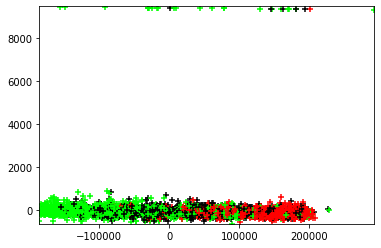

In [9]:
DEC.load_weights(model_path + '/DECweights')
D_clus = DEC.predict(D_train, verbose=0)
D_clus = D_clus.argmax(1)
plot_cluster(D_train, D_clus, n_clusters)

## train SCCN

In [10]:
def BranchRModel(rdims, bdims):
    inp = Input(shape=(R_train.shape[-1], ), name='recipient_input')
    r = inp
    r = BatchNormalization()(r)
    for i in range(len(rdims)-1):
        r = Dense(rdims[i], activation='relu', kernel_initializer='normal', name='r_representation_%d' % i)(r)
    r = BatchNormalization()(r)
    r = Dense(rdims[-1], activation='relu', kernel_initializer='normal', name='r_representation')(r)
    
    ys = []
    for i in range(n_clusters):
        z = Dense(bdims[0], activation='relu', kernel_initializer='normal', name='branch_%d_0' % i)(r)
        for j in range(1, len(bdims)):
            z = Dense(bdims[j], activation='relu', kernel_initializer='normal', name='branch_%d_%d' % (i, j))(z)
        z = Dense(1, activation='relu', kernel_initializer='normal', name='branch_%d' % i)(z)
        ys.append(z)
        
    ys = Concatenate()(ys)
    out = Concatenate()([ys, r, DEC.output])
    
    return Model(inputs=inp, outputs=ys), Model(inputs=[inp, DEC.input], outputs=out)

alpha = 10
beta = .2

def RMloss(y_true, y_pred):
    ys = y_pred[:, 0:n_clusters]
    r = y_pred[:, n_clusters:-n_clusters]
    tpred = y_pred[:, -n_clusters:]
    
    y = y_true[:, 0]
    p = y_true[:, 1:]
    
    ypred = K.sum(ys*tpred, axis=-1)
    yloss = K.square(ypred-y)
    tloss = KLD(p, tpred)
    
    tmean = K.mean(r, axis=0)
    tvar = K.var(r, axis=0)
    rloss = 0
    for i in range(n_clusters):
        w = K.reshape(p[:, i], shape=(-1, 1))
        weighted = r * w
        mean = K.mean(weighted, axis=0)
        var = K.var(weighted, axis=0)
        rloss += K.sum(K.square(mean-tmean)) + K.sum(K.square(var-tvar))
    
    return yloss + alpha*tloss + beta*rloss


def train_branch_r():
    BM, TBM = BranchRModel(rdims, bdims)
    TBM.compile(optimizer='Adam', loss=RMloss)
    checkpointer = ModelCheckpoint(filepath='./model/BranchRCheckpoint', verbose=1, save_best_only=True)

    DEC.load_weights(model_path + '/DECweights')

    history = {}
    history['loss'] = []
    history['val_loss'] = []
    for ite in range(10):
        q = DEC.predict(D_train, verbose=0)
        p = target_distribution(q)
    
        q_val = DEC.predict(D_test, verbose=0)
        p_val = target_distribution(q_val)
    
        target = np.hstack([y_train.reshape(-1, 1), p])
        target_val = np.hstack([y_test.reshape(-1, 1), p_val])
    
        hist = TBM.fit([R_train, D_train], target, validation_data=([R_test, D_test], target_val), batch_size=256, epochs=5, callbacks=[checkpointer])
        history['loss'] += hist.history['loss']
        history['val_loss'] += hist.history['val_loss']
    return BM, TBM, DEC, history
        
#TBM.save_weights(model_path + '/RTBMweights')

In [11]:
BM, TBM, DEC, hist = train_branch_r()
TBM.load_weights('./model/BranchRCheckpoint')
    
test_Y_pred = BM.predict(R_test)
test_T_pred = DEC.predict(D_test)

# expected loss
e_test_y_pred = np.sum(np.multiply(test_Y_pred, test_T_pred), axis=-1)
e_test_loss = np.mean(np.square(e_test_y_pred - y_test))

#absolute loss
a_test_clus = np.argmax(test_T_pred, axis=-1)
a_test_y_pred = test_Y_pred[np.arange(a_test_clus.size), a_test_clus]
a_test_loss = np.mean(np.square(a_test_y_pred - y_test))

print(np.log(e_test_loss))
print(np.log(a_test_loss))

Train on 4014 samples, validate on 446 samples
Epoch 1/5
4014/4014 [==============================] - 2s 401us/step - loss: 2434871.6345 - val_loss: 2564191.5504

Epoch 00001: val_loss improved from inf to 2564191.55045, saving model to ./model/BranchRCheckpoint
Epoch 2/5
4014/4014 [==============================] - 0s 71us/step - loss: 2432602.8614 - val_loss: 2553574.8722

Epoch 00002: val_loss improved from 2564191.55045 to 2553574.87220, saving model to ./model/BranchRCheckpoint
Epoch 3/5
4014/4014 [==============================] - 0s 63us/step - loss: 2401943.2673 - val_loss: 2417963.0673

Epoch 00003: val_loss improved from 2553574.87220 to 2417963.06726, saving model to ./model/BranchRCheckpoint
Epoch 4/5
4014/4014 [==============================] - 0s 65us/step - loss: 2164752.8852 - val_loss: 1753132.9372

Epoch 00004: val_loss improved from 2417963.06726 to 1753132.93722, saving model to ./model/BranchRCheckpoint
Epoch 5/5
4014/4014 [==============================] - 0s 56us

4014/4014 [==============================] - 0s 54us/step - loss: 490246.3140 - val_loss: 1484951.3346

Epoch 00004: val_loss did not improve from 1054370.39406
Epoch 5/5
4014/4014 [==============================] - 0s 52us/step - loss: 477751.8760 - val_loss: 1412856.5387

Epoch 00005: val_loss did not improve from 1054370.39406
Train on 4014 samples, validate on 446 samples
Epoch 1/5
4014/4014 [==============================] - 0s 52us/step - loss: 463046.0093 - val_loss: 1393450.9182

Epoch 00001: val_loss did not improve from 1054370.39406
Epoch 2/5
4014/4014 [==============================] - 0s 54us/step - loss: 470074.2216 - val_loss: 1502862.4467

Epoch 00002: val_loss did not improve from 1054370.39406
Epoch 3/5
4014/4014 [==============================] - 0s 53us/step - loss: 462089.7642 - val_loss: 1489814.4378

Epoch 00003: val_loss did not improve from 1054370.39406
Epoch 4/5
4014/4014 [==============================] - 0s 53us/step - loss: 437972.7296 - val_loss: 1518638.

916 2398 700


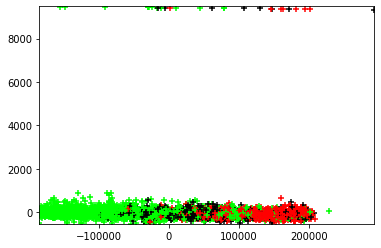

In [22]:
D_clus = DEC.predict(D_train, verbose=0)
D_clus = D_clus.argmax(1)
plot_cluster(D_train, D_clus, n_clusters)

a0 = np.sum(np.where(D_clus==0, 1, 0))
a1 = np.sum(np.where(D_clus==1, 1, 0))
a2 = np.sum(np.where(D_clus==2, 1, 0))
print(a0, a1, a2)

# Simulation

## Real

In [8]:
REG = REGModel()
REG.load_weights('./model/REGweights')

X = np.vstack([X_train, X_test])
np.random.shuffle(X)
y = REG.predict(X).reshape(-1)

total_survival = 0
total_benefit = 0
death_count = 0

S = np.copy(SS)

for i in range(len(X)):
    
    if len(y) < 1:
        break
    
    total_benefit += max(0, y[0] - S[0])
    total_survival += y[0]
    
    y = y[1:]
    S = S[1:]
    
    total_survival += len(S)
    
    S -= 1
    death_count += np.sum(np.where(S==0, 1, 0))
    non_zero = np.nonzero(S)
    y = y[non_zero]
    S = S[non_zero]
    

# a = SS - np.arange(len(SS))
# death_count = np.sum(np.where(a<=0, 1, 0))
death_rate = death_count / len(X)

# b = np.where(a>0, a, y)
# b = y - b
# benefits = np.sum(np.where(b>0, b, 0))
mean_bene = total_benefit / (len(X) - death_count)

mean_survival = total_survival / len(X)

print(death_rate)
print(mean_bene)
print(mean_survival)

0.24170403587443945
500.37467443555295
2457.784784870404


## FCFS

In [9]:
total_benefit = 0
total_survival = 0
death_count = 0

REG = REGModel()
REG.load_weights('./model/REGweights')

R = np.copy(RR)
D = np.copy(DD)
S = np.copy(SS)

for i in range(len(D)):
    d = D[i]
    
    if len(S) < 1:
        break
        
    r = R[0]
    x = np.hstack([d, r]).reshape((1, -1))
    y = REG.predict(x)[0][0]
    total_survival += y
    benefit = y - S[0]
    benefit = max(0, benefit)
    total_benefit += benefit
    
    R = R[1:]
    S = S[1:]
    
    total_survival += len(S)
    
    S -= 1
    death_count += np.sum(np.where(S==0, 1, 0))
    non_zero = np.nonzero(S)
    R = R[non_zero]
    S = S[non_zero]
    
mean_benefit = total_benefit / (len(D) - death_count)
death_rate = death_count / len(D)
mean_survival = total_survival / len(D)

print(death_count)
print('death rate: ', death_rate)
print('mean benefit: ', mean_benefit)
print('mean survival: ', mean_survival)

1078
death rate:  0.24170403587443945
mean benefit:  460.3988763977267
mean survival:  2431.4856940059917


## Urgent First

In [10]:
total_benefit = 0
death_count = 0
total_survival = 0

REG = REGModel()
REG.load_weights('./model/REGweights')

R = np.copy(RR)
D = np.copy(DD)
S = np.copy(SS)

for i in range(len(D)):
    d = D[i]
    
    if len(S) < 1:
        break
    
    idx = np.argmin(S[:500])
    r = R[idx]
    
    x = np.hstack([d, r]).reshape((1, -1))
    y = REG.predict(x)[0][0]
    total_survival += y
    benefit = y - S[idx]
    benefit = max(0, benefit)
    total_benefit += benefit
    
    R = np.delete(R, idx, axis=0)
    S = np.delete(S, idx)
    
    total_survival += len(S)
    
    S -= 1
    death_count += np.sum(np.where(S==0, 1, 0))
    non_zero = np.nonzero(S)
    R = R[non_zero]
    S = S[non_zero]
    
mean_benefit = total_benefit / (len(D) - death_count)
death_rate = death_count / len(D)
mean_survival = total_survival / len(D)

print(death_count)
print('mean benefit: ', mean_benefit)
print('death rate: ', death_rate)
print('mean survival: ', mean_survival)

685
mean benefit:  638.0567815960006
death rate:  0.15358744394618834
mean survival:  2780.731799676493


## Best Predicted Outcome First

In [11]:
total_benefit = 0
death_count = 0
total_survival = 0

REG = REGModel()
REG.load_weights('./model/REGweights')
BM, TBM = BranchRModel(rdims, bdims)
TBM.load_weights('./model/BranchRCheckpoint')
# BM, RBM = BMCross(rdims, bdims)
# CLS = CLUS(cdims)
# RBM.load_weights('./model/AlterCheckpoint')
# CLS.load_weights('./model/CLSCheckpoint')

R = np.copy(RR)
D = np.copy(DD)
S = np.copy(SS)

for i in range(len(D)):
    d = D[i]
    
    if len(S) < 1:
        break
    
    rs = R[:500]
    ds = np.array([d])[np.zeros(len(rs)).astype('int')]
        
    ys = BM.predict(rs)
    ts = DEC.predict(ds)
    y = np.sum(ys * ts, axis=-1)
    y = y.reshape(-1)
    idx = np.argmax(y)
    
    r = R[idx]
    s = S[idx]
    x = np.hstack([d, r]).reshape(1, -1)
    y = REG.predict(x)[0][0]
    total_survival += y
    benefit = max(0, y - s)
    total_benefit += benefit
    
    R = np.delete(R, idx, axis=0)
    S = np.delete(S, idx)
    
    total_survival += len(S)
    
    S -= 1
    death_count += np.sum(np.where(S==0, 1, 0))
    non_zero = np.nonzero(S)
    R = R[non_zero]
    S = S[non_zero]
    
mean_benefit = total_benefit / (len(D) - death_count)
death_rate = death_count / len(D)
mean_survival = total_survival / len(D)

print(death_count)
print('mean benefit: ', mean_benefit)
print('death rate: ', death_rate)
print('mean survival: ', mean_survival)

1358
mean benefit:  388.7056117841769
death rate:  0.30448430493273543
mean survival:  2255.1112850394484


## Benefit First

In [12]:
total_benefit = 0
death_count = 0
total_survival = 0

REG = REGModel()
REG.load_weights('./model/REGweights')
BM, TBM = BranchRModel(rdims, bdims)
TBM.load_weights('./model/BranchRCheckpoint')
# BM, RBM = BMCross(rdims, bdims)
# CLS = CLUS(cdims)
# RBM.load_weights('./model/AlterCheckpoint')
# CLS.load_weights('./model/CLSCheckpoint')

R = np.copy(RR)
D = np.copy(DD)
S = np.copy(SS)

for i in range(len(D)):
    d = D[i]
    
    if len(S) < 1:
        break
    
    rs = R[:500]
    ds = np.array([d])[np.zeros(len(rs)).astype('int')]
        
    ys = BM.predict(rs)
    ts = DEC.predict(ds)
    y = np.sum(ys * ts, axis=-1)
    y = y.reshape(-1)
    potential_benefits = y - S[:500]
    idx = np.argmax(potential_benefits)
    
    r = R[idx]
    s = S[idx]
    x = np.hstack([d, r]).reshape(1, -1)
    y = REG.predict(x)[0][0]
    total_survival += y
    benefit = max(0, y - s)
    total_benefit += benefit
    
    R = np.delete(R, idx, axis=0)
    S = np.delete(S, idx)
    
    total_survival += len(S)
    
    S -= 1
    death_count += np.sum(np.where(S==0, 1, 0))
    non_zero = np.nonzero(S)
    R = R[non_zero]
    S = S[non_zero]
    
mean_benefit = total_benefit / (len(D) - death_count)
death_rate = death_count / len(D)
mean_survival = total_survival / len(D)

print(death_count)
print('mean benefit: ', mean_benefit)
print('death rate: ', death_rate)
print('mean survival: ', mean_survival)

695
mean benefit:  633.6750256157175
death rate:  0.15582959641255606
mean survival:  2770.571443284039


## Best Donor Type First

In [20]:
REG = REGModel()
REG.load_weights('./model/REGweights')

mean_benes = []
death_rates = []
death_counts = []
mean_survivals = []

for j in range(1):
    BM, TBM, DEC, hist = train_branch_r()
    TBM.load_weights('./model/BranchRCheckpoint')
    
    total_benefit = 0
    death_count = 0
    fail_count = 0
    total_survival = 0
    
    R = np.copy(RR)
    D = np.copy(DD)
    S = np.copy(SS)

    for i in range(len(D)):
        d = D[i]
    
        if len(S) < 1:
            break
        
        ts = DEC.predict(d.reshape(1, -1))
        t = np.argmax(ts)
    
        rs = R[:500]
        ys = BM.predict(rs)
        bts = np.argmax(ys, axis=-1)
        idxs = np.where(bts==t)[0]
        if len(idxs) > 0:
            idx = idxs[0]
        else:
            fail_count += 1
            ts = np.repeat(ts, len(rs), axis=0)
            y = np.sum(ys * ts, axis=-1)
            y = y.reshape(-1)
            potential_benefits = y - S[:500]
            idx = np.argmax(potential_benefits)
   
        r = R[idx]
        s = S[idx]
        x = np.hstack([d, r]).reshape(1, -1)
        y = REG.predict(x)[0][0]
        total_survival += y
        benefit = max(0, y - s)
        total_benefit += benefit
    
        R = np.delete(R, idx, axis=0)
        S = np.delete(S, idx)
        
        total_survival += len(S)
    
        S -= 1
        death_count += np.sum(np.where(S==0, 1, 0))
        non_zero = np.nonzero(S)
        R = R[non_zero]
        S = S[non_zero]
    
    mean_benefit = total_benefit / (len(D) - death_count)
    death_rate = death_count / len(D)
    mean_survival = total_survival / len(D)
    
    mean_benes.append(mean_benefit)
    death_rates.append(death_rate)
    death_counts.append(death_count)
    mean_survivals.append(mean_survival)


Train on 4014 samples, validate on 446 samples
Epoch 1/5
4014/4014 [==============================] - 2s 441us/step - loss: 2424411.4264 - val_loss: 2657801.2018

Epoch 00001: val_loss improved from inf to 2657801.20179, saving model to ./model/BranchRCheckpoint
Epoch 2/5
4014/4014 [==============================] - 0s 63us/step - loss: 2421302.8006 - val_loss: 2643962.3083

Epoch 00002: val_loss improved from 2657801.20179 to 2643962.30830, saving model to ./model/BranchRCheckpoint
Epoch 3/5
4014/4014 [==============================] - 0s 63us/step - loss: 2377795.8213 - val_loss: 2470428.9260

Epoch 00003: val_loss improved from 2643962.30830 to 2470428.92601, saving model to ./model/BranchRCheckpoint
Epoch 4/5
4014/4014 [==============================] - 0s 63us/step - loss: 2059059.5859 - val_loss: 1741708.2651

Epoch 00004: val_loss improved from 2470428.92601 to 1741708.26513, saving model to ./model/BranchRCheckpoint
Epoch 5/5
4014/4014 [==============================] - 0s 61us

4014/4014 [==============================] - 0s 56us/step - loss: 449028.4940 - val_loss: 1654435.7096

Epoch 00004: val_loss did not improve from 1117058.22870
Epoch 5/5
4014/4014 [==============================] - 0s 55us/step - loss: 428702.9913 - val_loss: 1727244.4148

Epoch 00005: val_loss did not improve from 1117058.22870
Train on 4014 samples, validate on 446 samples
Epoch 1/5
4014/4014 [==============================] - 0s 54us/step - loss: 426361.8943 - val_loss: 1689526.9714

Epoch 00001: val_loss did not improve from 1117058.22870
Epoch 2/5
4014/4014 [==============================] - 0s 54us/step - loss: 419013.5909 - val_loss: 1698066.0308

Epoch 00002: val_loss did not improve from 1117058.22870
Epoch 3/5
4014/4014 [==============================] - 0s 54us/step - loss: 413328.3134 - val_loss: 1750310.4591

Epoch 00003: val_loss did not improve from 1117058.22870
Epoch 4/5
4014/4014 [==============================] - 0s 54us/step - loss: 401418.4714 - val_loss: 1809235.

In [21]:
print(fail_count)
print(mean_benefit)
print(death_rate)
print(mean_survival)

635
477.4980636902411
0.26143497757847534
2382.4473893913987


In [14]:
print(np.mean(np.sort(mean_benes)[-10:]))
print(np.mean(np.sort(death_rates)[:10]))
print(np.mean(np.sort(mean_survivals)[-10:]))

data = {}
data['death_counts'] = list(np.array(death_counts).astype('float'))
data['mean_benefits'] = list(np.array(mean_benes).astype('float'))
data['mean_survivals'] = list(np.array(mean_survivals).astype('float'))
data['death_rates'] = list(np.array(death_rates).astype('float'))

with open('./model/allocBDTF.json', 'w+', encoding='utf8') as f:
    f.write(json.dumps(data, ensure_ascii=False))

632.2769969213097
0.15816143497757848
2755.69162719239


In [2]:
with open('./model/allocBDTF.json', 'r', encoding='utf8') as f:
    data = json.loads(f.read())
    
death_rates = np.array(data['death_rates'])
mean_benes = np.array(data['mean_benefits'])
mean_survivals = np.array(data['mean_survivals'])

In [4]:
print(np.mean(np.sort(mean_benes)[-3:]))
print(np.mean(np.sort(death_rates)[:3]))
print(np.mean(np.sort(mean_survivals)[-3:]))

654.338829523656
0.15665171898355754
2762.6914834756667


In [19]:
(2762 - 2457) / 2457

0.12413512413512413